# PID Robot Car mit Noise

In [1]:
%matplotlib widget

import matplotlib as mpl
import matplotlib.pyplot as plt
from ipywidgets import Button, FloatSlider, VBox
import numpy as np
from matplotlib.patches import Rectangle, Polygon, Arrow
from matplotlib.collections import PatchCollection
import time

In [2]:
# Define a RobotCar class
class RobotCar:
    def __init__(self, control_fct, initial_pose=[0., 4., 0.], command=[0.1, 0.]):
        self.pose = np.array(initial_pose)  # Robot's pose [x, y, theta]
        self.command = np.array(command)  # Robot's command [velocity, turning angle]
        self.hist_pos = np.array([[0.], [4.]])  # History of robot's positions for plotting

        self.control_function = control_fct

        # Create a figure and axis
        fig, ax = plt.subplots(1, 1, figsize=(16, 4))

        self.fig = fig
        self.ax = ax
        # Set the axis limits and aspect ratio
        self.ax.set_xlim(-1, 47)
        self.ax.set_ylim(-6, 6)
        self.ax.set_aspect('equal')

        self.error = 0.

        self.ax.plot([-2.,48], [0.,0.], color="green")

        self.init_visualization_patches()
        self.prev_error = -self.pose[1]
        self.integrated_error = 0.

        # Introduce noise and systematic error
        self.noise_level = 0. # Describes the width of zero centered gaussian noise, the standard deviation
        self.systematic_steering_error = 0.002 # simply added onto the steering angle: Use 0.002 as an example
        # Steering is in a range of -0.03 to 0.03; so should be quite small!
        # Positive is steering left ("turn to top").

    def init_visualization_patches(self):
        # Create the robot body and wheels
        v_initial = [[-1, -0.5], [-1, 0.5], [1, 0.5], [1, -0.5]]
        body = Polygon(v_initial, closed=True, fc='r', ec='gray')
        left_front_wheel = Rectangle((0.3, 0.5), 0.4, 0.1, fc='gray', ec='black', lw=3)
        left_hind_wheel = Rectangle((-0.7, 0.5), 0.4, 0.1, fc='gray', ec='black', lw=3)
        right_front_wheel = Rectangle((0.3, -0.5), 0.4, 0.1, fc='gray', ec='black', lw=3)
        right_hind_wheel = Rectangle((-0.7, -0.5), 0.4, 0.1, fc='gray', ec='black', lw=3)

        self.robot = PatchCollection([body, left_front_wheel,left_hind_wheel, right_front_wheel,right_hind_wheel], match_original=True)
        self.arrow_left = Arrow(1,0,1,0, width=0.5, color="blue")
        # Add the patches to the axis
        self.ax.add_collection( self.robot )
        self.arr_hook = self.ax.add_patch( self.arrow_left )

        self.line_robot_hist, = self.ax.plot(self.hist_pos[0], self.hist_pos[1], zorder=0)

    def update_visualization(self):
        # Update the visualization of the robot's pose and history
        r = mpl.transforms.Affine2D().rotate(self.pose[2])
        t = mpl.transforms.Affine2D().translate(self.pose[0], self.pose[1])
        tra = r + t + self.ax.transData
        self.robot.set_transform(tra)
        self.line_robot_hist.set_data(self.hist_pos)
        self.arr_hook.remove()
        self.arrow_left = Arrow(1, 0, 1, self.command[1] * 15, width=0.5, color="blue")
        self.arr_hook = self.ax.add_patch( self.arrow_left )
        self.arrow_left.set_transform(tra)

    def reset_position(self, button):
        # Reset the position of the robot
        self.pose = np.array([0., 4., 0.])
        self.hist_pos = np.array([[0.], [4.]])
        self.update_visualization()

    def simulate_one_step(self, button):
        self.prev_error = self.error
        self.error = -self.pose[1] + self.noise_level * np.random.normal()
        self.integrated_error += self.error
        self.command[1] = self.control_function( self.error , self.prev_error, self.integrated_error, self.systematic_steering_error )
        if self.command[1] < -0.03:
            self.command[1] = -0.03
        elif self.command[1] > 0.03:
            self.command[1] = 0.03 
        # Simulate one step of the robot's motion
        self.pose[0] += np.cos(self.pose[2]) * self.command[0]
        self.pose[1] += np.sin(self.pose[2]) * self.command[0]
        self.pose[2] += self.command[1]
        self.hist_pos = np.append(self.hist_pos, np.array([[self.pose[0]], [self.pose[1]]]), axis=1)
        #self.update_visualization()
        #self.fig.canvas.draw()

    def simulation_run_anim(self, steps=400, button=None):
        # Run the simulation for a certain number of steps
        for i in range(0, 100):
            self.simulate_one_step(button)
            self.update_visualization()
            self.fig.canvas.draw()
            #time.sleep(0.02)

    def simulation_run(self,  button=None):
        # Run the simulation for a certain number of steps
        for i in range(0, 600):
            self.simulate_one_step(button)
            #time.sleep(0.02)
        self.update_visualization()
        self.fig.canvas.draw()

In [3]:
def control_function( error , prev_error, integrated_error, steering_drift ):
    K_p = 0.0
    K_d = 0.0
    K_i = 0.0
    steering = np.sign(error)
    return steering_drift + steering

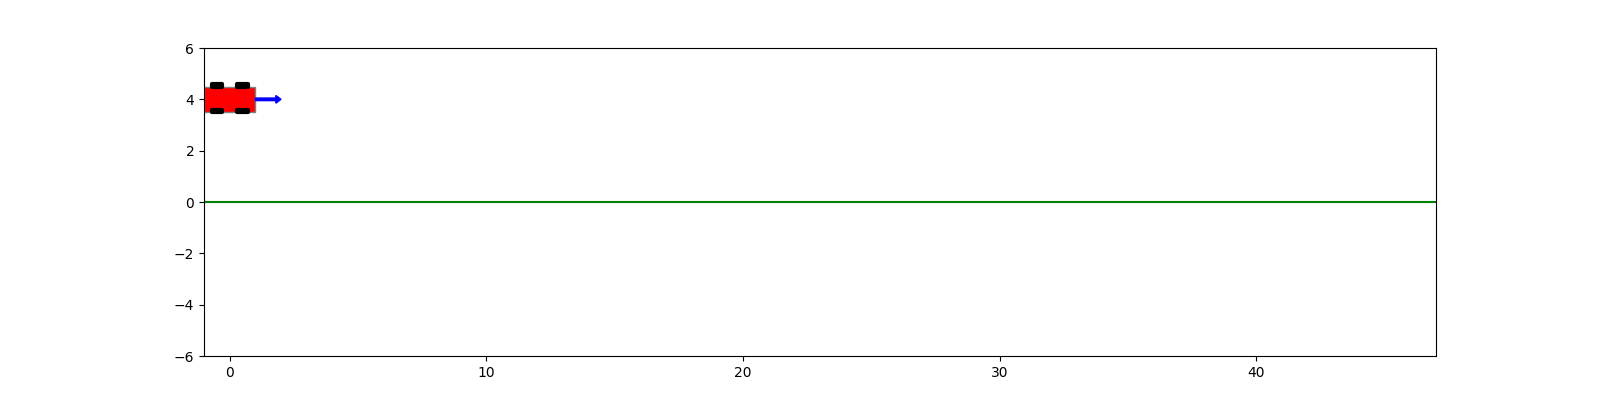

In [4]:
# Create buttons and sliders for simulation control
button_reset = Button(description="Reset")
button_step = Button(description="Step")
button_run_anim = Button(description="Run Animation")
button_run = Button(description="Run 600 it")

# Create a RobotCar instance
robot_car = RobotCar( control_function )

# Define the event handlers for buttons and sliders
button_reset.on_click(robot_car.reset_position)
button_step.on_click(robot_car.simulate_one_step)
button_run_anim.on_click(robot_car.simulation_run_anim)
button_run.on_click(robot_car.simulation_run)

# Display the buttons and sliders in a VBox
controls = VBox([button_reset, button_step, button_run_anim, button_run])
display(controls)

# Start the simulation
robot_car.update_visualization()
plt.show()